# Residual Plot Analysis — ExoALMA Data

This notebook analyzes residual plots from the ExoALMA program (Curone et al. 2025, Paper IV) to extract flux limits potentially associated with planet-forming signatures within the annuli of protoplanetary disks. The aim is not to spatially characterize these features — which are likely unresolved — but to constrain potential circumplanetary disk (CPD) properties using up-to-date CPD emission models, and to compare model performance in terms of predictive power.

**Reference**:  
Curone, P., Facchini, S., Andrews, S. M., et al. (2025). *exoALMA. IV. Substructures, Asymmetries, and the Faint Outer Disk in Continuum Emission*. *The Astrophysical Journal Letters*, **984**(1), L9. https://doi.org/10.3847/2041-8213/adc438


In [2]:
# import necessary libraries

import os  
import numpy as np  
import re  # Python’s regular expressions module to extract numbers from filenames
from astropy.io import fits
import pandas as pd
from gofish import imagecube
import matplotlib.pyplot as plt



In [3]:
# Load the residual fits file for each disk and store them in class then in object  

# --------------------------------------------------------
# Define a class (stores functions) for handling each disk
# --------------------------------------------------------
class DiskResiduals:
    def __init__(self, name, path, geom_file):
        """
        Initializes a DiskResiduals object for one disk.
        - name: Disk name (e.g., 'AA_Tau')
        - path: Path to its residuals folder
        - geom_file: Full path to geometry .txt file
        """
        self.name = name
        self.path = path
        self.inc, self.PA, self.center = self._load_geometry(geom_file)
        self.residuals = {}  # Dict to store {Briggs index value: FITS data}

    def _load_geometry(self, filepath):
        """
        Reads a galario geometry .txt file and returns (inc, PA, (dRA, dDec)).
        """
        with open(filepath, "r") as f:
            lines = [line for line in f.readlines() if not line.startswith("#")]
        best_fit = [float(x) for x in lines[0].split()]
        inc, PA, dRA, dDec = best_fit
        return inc, PA, (dRA, dDec)

    def load_residuals(self):
        """
        Load all .fits residuals in the folder and store them by Briggs Index.
        """
        for fname in os.listdir(self.path):
            if fname.endswith(".fits"):
                match = re.search(r"robust([-\d.]+)", fname)
                briggs_index = match.group(1) if match else "unknown"
                full_path = os.path.join(self.path, fname)
                with fits.open(full_path) as hdul:
                    self.residuals[briggs_index] = hdul[0].data

# -----------------------------------------------------
# Load all disks into a dictionary of DiskResiduals objects
# -----------------------------------------------------
data_dir = "D:/exoALMA_disk_data"  # Use forward slashes for Windows or raw string
all_disks = {}

for disk in os.listdir(data_dir):
    res_path = os.path.join(data_dir, disk, "images_frank_residuals_different_robust")
    geom_file = os.path.join(data_dir, disk, f"{disk}_geometrical_parameters_continuum_galario.txt")

    if os.path.isdir(res_path) and os.path.exists(geom_file):
        disk_obj = DiskResiduals(disk, res_path, geom_file)
        disk_obj.load_residuals()
        all_disks[disk] = disk_obj

In [4]:
# Display a summary of all_disks

for disk_name, disk_obj in all_disks.items():
    print(f"Disk: {disk_name}")
    print(f"  Inclination: {disk_obj.inc:.2f} deg")
    print(f"  PA: {disk_obj.PA:.2f} deg")
    print(f"  Center offset: {disk_obj.center}")
    print(f"  Residuals (Briggs indices): {list(disk_obj.residuals.keys())}")
    print("-" * 40)

Disk: AA_Tau
  Inclination: 58.54 deg
  PA: 93.77 deg
  Center offset: (-0.00545897, 0.00482739)
  Residuals (Briggs indices): ['0.0.', '-0.5.', '0.5.', '-1.0.', '1.0.', '-1.5.', '-2.0.', '2.0.']
----------------------------------------
Disk: CQ_Tau
  Inclination: 35.24 deg
  PA: 53.87 deg
  Center offset: (-0.00871044, 0.0009941)
  Residuals (Briggs indices): ['0.0.', '-0.5.', '0.5.', '-1.0.', '1.0.', '-1.5.', '1.5.', '-2.0.', '2.0.']
----------------------------------------
Disk: DM_Tau
  Inclination: 35.97 deg
  PA: 155.60 deg
  Center offset: (-0.00551499, -0.00658999)
  Residuals (Briggs indices): ['0.0.', '-0.5.', '0.5.', '-1.0.', '1.0.', '-1.5.', '1.5.', '-2.0.', '2.0.']
----------------------------------------
Disk: HD_135344B
  Inclination: 20.73 deg
  PA: 28.92 deg
  Center offset: (0.0007974, -0.00320815)
  Residuals (Briggs indices): ['0.0.', '-0.5.', '0.5.', '-1.0.', '1.0.', '-1.5.', '1.5.', '-2.0.', '2.0.']
----------------------------------------
Disk: HD_143006
  Inclin

In [ ]:
# Plot the residual radial profile for each disk overlaid on the full disk profile
# Need to add the geometry of the disk to the class
# add a method to the class to plot the residual radial profile
# change the class to not only store the residuals, but all the information about the disk
# and label them clearly
# Problem: the displayed image is not the same as shown in paper, this has units of flux, that one is SNR

The frank model generates synthetic visibilities, which are subtracted from the observed visibilities to produce residual visibilities. These residuals are then imaged using the CLEAN algorithm, resulting in a residual map. Like other radio continuum images, this map has units of flux density per beam (e.g., Jy/beam). To express the residuals in terms of signal-to-noise ratio (SNR), as done in Figure 3 of the exoALMA IV paper, the observed rms noise corresponding to each robust weighting must be extracted from the original image and used to rescale the residual flux densities.

However, since protoplanetary disks are best studied in concentric radial rings from the central star, it's important to consider that the noise level varies with radius. At larger disk radii, more ALMA beams cover each ring, which reduces the azimuthally averaged noise. In contrast, the inner disk tends to show brighter emission but fewer independent beams per bin. Therefore, the azimuthally averaged rms noise within each radial ring provides the most effective way to separate planet-induced substructure signals from noise.

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


Text(0, 0.5, 'Integrated Intensity (Jy/beam m/s)')

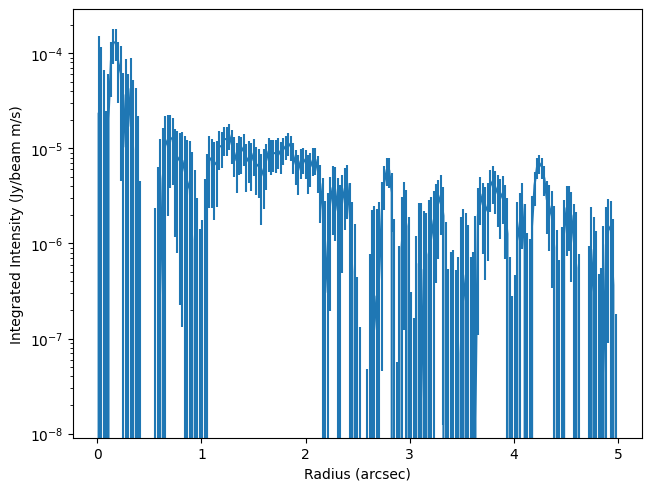

In [5]:
# A simple example plot of the nonaxisymmetric residuals for disk AA_Tau with robust value 0.5
# Adapting from section 4.2 of the exoALMA X paper




cube = imagecube('D:\exoALMA_disk_data\AA_Tau\images_frank_residuals_different_robust\AA_Tau_continuum_resid_robust0.5.image.fits', FOV=10.0)

x, y, dy = cube.radial_profile(inc=58.54, PA=155.6)

fig, ax = plt.subplots(constrained_layout=True)
ax.errorbar(x, y, dy)
ax.set_yscale('log')
ax.set_xlabel('Radius (arcsec)')
ax.set_ylabel('Integrated Intensity (Jy/beam m/s)')

